## Описание проекта
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.     
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.     

Поставленные задачи:       
* Задача №1: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Для этой задачи заказчик предоставил данные с признаками:
  - id — уникальный идентификатор сотрудника;
  - dept — отдел, в котором работает сотрудник;
  - level — уровень занимаемой должности;
  - workload — уровень загруженности сотрудника;
  - employment_years — длительность работы в компании (в годах);
  - last_year_promo — показывает, было ли повышение за последний год;
  - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
  - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
  - salary — ежемесячная зарплата сотрудника;
  - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

       
* Задача № 2: предсказание увольнения сотрудника из компании. Целевой признак quit — увольнение сотрудника из компании.

# Задача №1: модель, предсказывающая уровень удовлетворённости сотрудника.

## 1.1. Изучение общей информации о датасетах

In [5]:
!pip install phik -q

In [6]:
!pip install --upgrade scikit-learn -q

In [7]:
!pip install --upgrade seaborn matplotlib -q

In [8]:
!pip install --upgrade contourpy -q

In [9]:
pip install --upgrade matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install shap  -q

In [11]:
!pip install lightgbm -q

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import phik
import shap
import lightgbm as lgb

from IPython.display import Image
from lightgbm import (
    LGBMRegressor,
    LGBMClassifier
)

from sklearn.dummy import DummyClassifier
from matplotlib.pyplot import rcParams, rcParamsDefault
from matplotlib import transforms
from scipy import stats as st
from scipy.stats import norm
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)

from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.metrics import (
    roc_auc_score, 
    make_scorer
)

from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import (
     DecisionTreeRegressor,
     DecisionTreeClassifier
)

from sklearn.neighbors import (
     KNeighborsClassifier, 
     KNeighborsRegressor
)

from mlxtend.plotting import plot_decision_regions
from itertools import combinations

In [13]:
# Создадим функцию для получения первичной информации по датасету.
def get_data_info(data):
    display(data.sample(3))
    display(data.info())
    display(data.describe(include='all'))
    display('Количество явных дубликатов:', data.duplicated().sum())

In [14]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path)
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url)
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

In [15]:
train_job = load_data('/Users/gulnaravolodina/Downloads/train_job_satisfaction_rate.csv', 
                 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

Данные успешно загружены из локального файла.


In [16]:
get_data_info(train_job)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
785,899274,technology,junior,medium,3,no,yes,3,30000,0.20
1291,654625,purchasing,middle,low,5,no,no,4,19200,0.59
585,279753,purchasing,sinior,low,7,no,no,1,38400,0.57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.621000,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,257883.104622,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322836.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771446.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


'Количество явных дубликатов:'

0

В датасете train_job есть пропущенные значения, тип данных соответствует значениям, синтаксис соблюден.

In [18]:
test_features = load_data('/Users/gulnaravolodina/Documents/test_features.csv', 
                 'https://code.s3.yandex.net/datasets/test_features.csv')

Ошибка при загрузке данных из локального файла: [Errno 1] Operation not permitted: '/Users/gulnaravolodina/Documents/test_features.csv'
Данные успешно загружены из URL.


In [19]:
get_data_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1951,960114,sales,junior,low,4,no,no,3,15600
164,912872,hr,middle,low,3,no,no,4,25200
1900,677509,sales,junior,medium,1,no,no,3,20400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


'Количество явных дубликатов:'

0

В датасете test_features есть пропущенные значения, тип данных соответствует значениям, синтаксис соблюден. Также в ряде признаков больше категорий, чем в датасете train_job (признаки dept, workload) 

In [21]:
target_job_satisfaction = load_data('/Users/gulnaravolodina/Documents/test_target_job_satisfaction_rate.csv', 
                 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Ошибка при загрузке данных из локального файла: [Errno 1] Operation not permitted: '/Users/gulnaravolodina/Documents/test_target_job_satisfaction_rate.csv'
Данные успешно загружены из URL.


In [22]:
get_data_info(target_job_satisfaction)

,id,job_satisfaction_rate
587,125082,0.18
1342,545992,0.63
472,648850,0.79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


'Количество явных дубликатов:'

0

В датасете target_job_satisfaction нет пропущенных значений, тип данных соответствует значениям, синтаксис соблюден.

### Выводы по первому этапу:
Получено 3 датасета:
- train_job, состоящий из 4000 строк;
- test_features, состоящий из 2000 строк, столбцы dept и workload имеют количество значений, чем аналогичные в датасете train_job;
- target_job_satisfaction, состоящий из 2000 строк.    
В датасетах явные дубликаты отсутствуют, в данных есть пропуски, данных достаточно для анализа.

## 1.2. Предобработка данных

In [27]:
# заменим опечатку в данных
train_job['level'] = train_job['level'].str.replace('sinior','senior')
test_features['level'] = test_features['level'].str.replace('sinior','senior')

In [28]:
# выведем все строки с пропущенными значениями в train_job
train_job[train_job['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [29]:
train_job[train_job['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [30]:
# выведем все строки с пропущенными значениями в test_features
test_features[test_features['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [31]:
test_features[test_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [32]:
# выведем уникальные значения в датасете test_features, чтобы найти "лишние" значения в категориальных признаках
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [33]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [34]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [35]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Заменим " " в признаке dept и в признаке workload на nan, чтобы обработать все пропуски в пайплайне

In [37]:
test_features['dept'].replace({' ': np.nan}, inplace=True)
test_features['workload'].replace({' ': np.nan}, inplace=True)

In [38]:
display(test_features['dept'].unique())
display(test_features['workload'].unique())

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

array(['medium', 'low', 'high', nan], dtype=object)

In [39]:
# посмотрим медианные значения заработной платы исходя из уровня специалиста
median_salary = train_job.groupby('level')['salary'].median()
median_salary

level
junior    24000.0
middle    39600.0
senior    56400.0
Name: salary, dtype: float64

In [40]:
median_salary = test_features.groupby('level')['salary'].median()
median_salary

level
junior    24000.0
middle    39600.0
senior    61200.0
Name: salary, dtype: float64

In [41]:
# посмотрим медианные значения заработной платы исходя из департамента
median_salary_dept = train_job.groupby('dept')['salary'].median()
median_salary_dept

dept
hr            30000.0
marketing     31200.0
purchasing    28800.0
sales         27600.0
technology    34800.0
Name: salary, dtype: float64

Исходя из медианных значений по уровням должностей и департаментов, можно сделать вывод, что пропущены данные по уровню junior в департаменте продаж. Так как это самое часто встречающееся значение, используем этот параметр  в simpleImputer.
Данные по уровню загрузки также заменим на часто встречающееся значение

In [43]:
cat_imputer = Pipeline(
    [('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

In [44]:
# обработаем пропущенные значения
cat_features = ['dept','level','workload']
train_job[cat_features] = cat_imputer.fit_transform(train_job[cat_features])
test_features[cat_features] = cat_imputer.transform(test_features[cat_features])

In [49]:
# проверим замену
[{i: list(train_job[i].unique())} for i in train_job[['dept', 'level']]]

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing']},
 {'level': ['junior', 'middle', 'senior']}]

In [50]:
[{i: list(test_features[i].unique())} for i in test_features[['dept', 'level', 'workload']]]

[{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology']},
 {'level': ['junior', 'middle', 'senior']},
 {'workload': ['medium', 'low', 'high']}]

### Выводы по этапу предобработки данных:
- исправлена опечатка в названии уровня senior;
- исправлены «пробелы» вместо данных в столбцах dept и workload датасета test_features;
- в датасетах train_job и test_features исправлены пропущенные значения в столбцах dept, level и workload при помощи SimpleImputer;
- дополнительно проверили корректность замены на часто встречающееся значение, посмотрев медианные зарплаты по уровню должности и департаменту. Действительно, такие зарплаты по столбцам с пропущенными значениями соответствуют уровню junior в департаменте продаж (а это как раз часто встречающееся значение).

## 1.3. Исследовательский анализ данных

In [54]:
# создадим функцию для построения графиков, чтобы посмотреть распределение непрерывных количественных данных
# построим диаграмму размаха
def create_plots(data, xname, yname, title):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].hist(data, density=True, alpha=0.6, color='g')

    # Вычисляем параметры нормального распределения
    mu = np.mean(data) 
    sigma = np.std(data) 

    # Создаем значения X для линии нормального распределения
    x = np.linspace(min(data), max(data), 100)
    # Вычисляем значения функции плотности вероятности нормального распределения
    p = norm.pdf(x, mu, sigma)

    # Добавляем линию нормального распределения на гистограмму
    ax[0].plot(x, p, 'k', linewidth=2)
    
    # Строим диаграмму размаха
    sns.boxplot(x=data, showfliers=False, ax=ax[1])
      
    ax[0].set_xlabel(xname)
    ax[0].set_ylabel(yname)  
    ax[1].set_xlabel(xname)
    ax[1].set_ylabel(yname)     
   
    plt.tight_layout()
    plt.suptitle(title, fontsize=10, y=1.05)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [55]:
# создадим функцию для построения графиков, чтобы посмотреть распределение дискретных количественных данных
def creat_plot_views(data, xname, title):
    sns.set_style("darkgrid")
    sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend = False)
    
    plt.xlabel(xname)
    plt.ylabel('Количество сотрудников')
    plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

In [56]:
# создадим функцию для построения графиков, чтобы посмотреть распределение категориальных данных
def create_barh(data, xname, yname, title):
    sns.set_style("darkgrid")
    colors = ['salmon', 'lightgreen','lightblue', 'lightgrey', 'orange', 'pink', 'lavender', 'lightyellow'] * (len(data) // 7 + 1)
    colors = colors[:len(data)]   

    ax = data.plot(kind='barh', color=colors, figsize=(7, 4))  
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(title)
    
    # Добавляем аннотации для каждого столбца
    total = sum(data)
    for i in range(len(data)):
        val = data.iloc[i]
        percent = (val / total) * 100
        ax.annotate(f" ({round(percent)}%)", 
                    xy=(val, i), 
                    xytext=(5, 0), 
                    textcoords="offset points", 
                    fontsize=9,
                    va='center')

    plt.tight_layout()
    plt.show()

### Исследуем датасет train_job

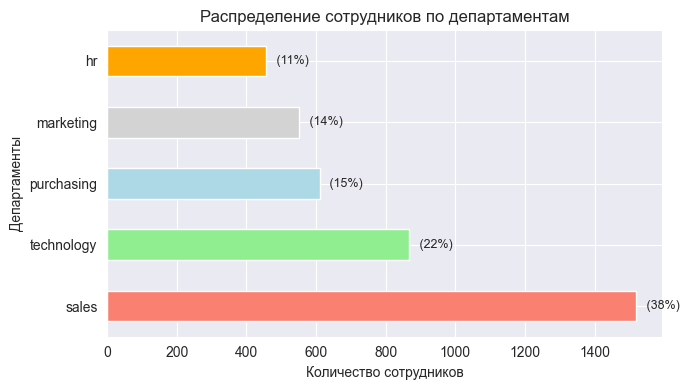

array(['sales', 'hr', 'technology', 'purchasing', 'marketing'],
      dtype=object)

In [58]:
create_barh(train_job.dept.value_counts(), 'Количество сотрудников', 'Департаменты',
            'Распределение сотрудников по департаментам')
train_job.dept.unique()

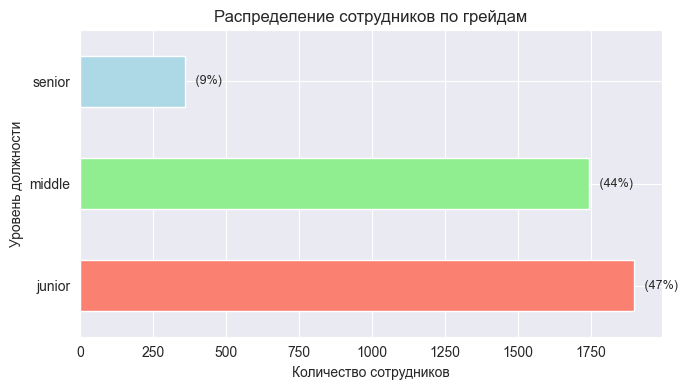

array(['junior', 'middle', 'senior'], dtype=object)

In [59]:
create_barh(train_job.level.value_counts(), 'Количество сотрудников', 'Уровень должности', 
            'Распределение сотрудников по грейдам')
train_job.level.unique()

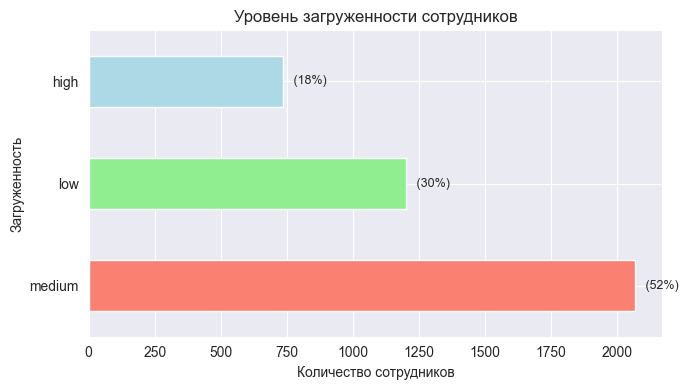

array(['medium', 'high', 'low'], dtype=object)

In [60]:
create_barh(train_job.workload.value_counts(), 'Количество сотрудников', 'Загруженность',
            'Уровень загруженности сотрудников')
train_job.workload.unique()

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/308338361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend = False)


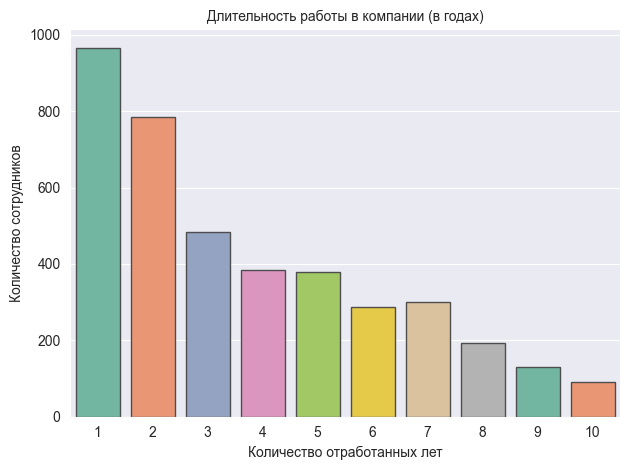

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [61]:
creat_plot_views(train_job.employment_years, 'Количество отработанных лет', 
            'Длительность работы в компании (в годах)')
train_job.employment_years.unique()

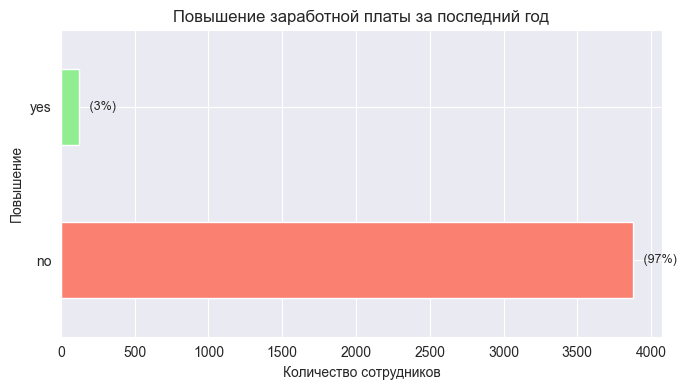

array(['no', 'yes'], dtype=object)

In [62]:
create_barh(train_job.last_year_promo.value_counts(),'Количество сотрудников', 'Повышение',
            'Повышение заработной платы за последний год')
train_job.last_year_promo.unique()

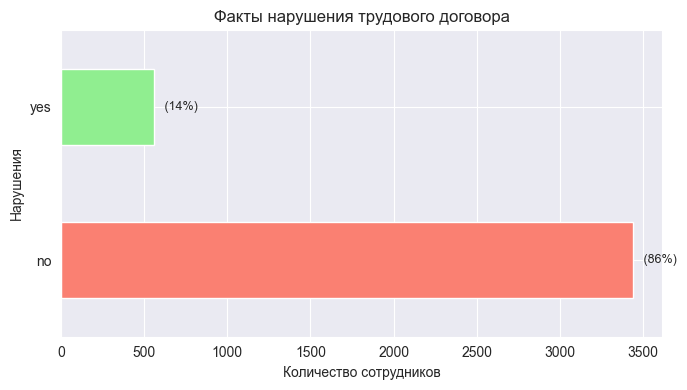

array(['no', 'yes'], dtype=object)

In [63]:
create_barh(train_job.last_year_violations.value_counts(),'Количество сотрудников', 'Нарушения',
            'Факты нарушения трудового договора')
train_job.last_year_violations.unique()

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/308338361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend = False)


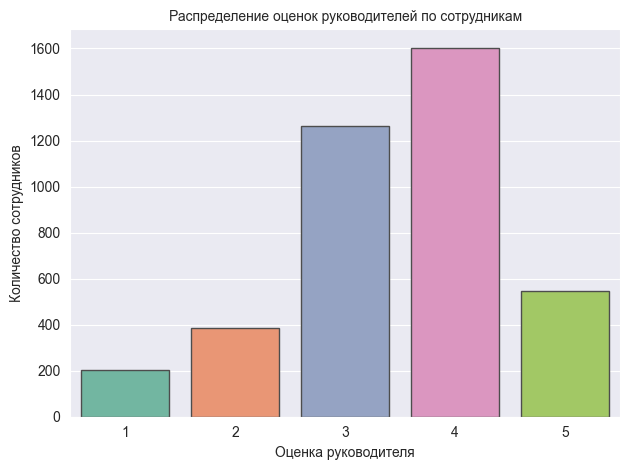

array([1, 5, 2, 3, 4])

In [64]:
creat_plot_views(train_job.supervisor_evaluation, 'Оценка руководителя', 
            'Распределение оценок руководителей по сотрудникам')
train_job.supervisor_evaluation.unique()

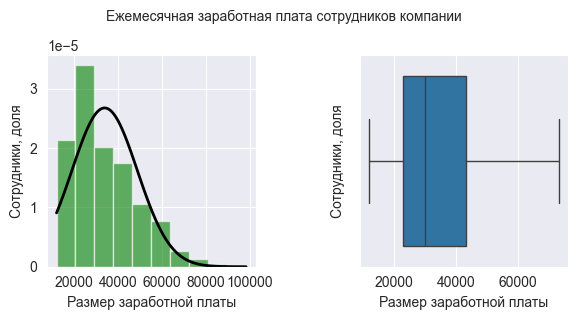

In [65]:
create_plots(train_job.salary, 'Размер заработной платы','Cотрудники, доля',
             'Ежемесячная заработная плата сотрудников компании')

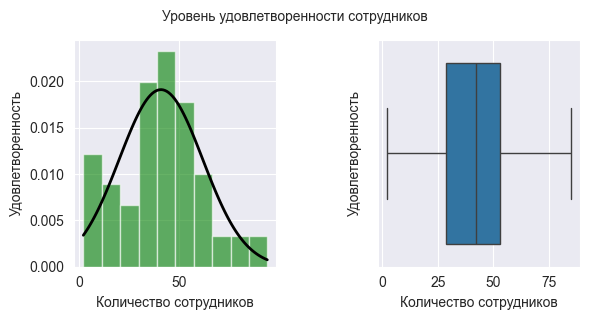

In [66]:
create_plots(train_job.job_satisfaction_rate.value_counts(),'Количество сотрудников', 'Удовлетворенность',
            'Уровень удовлетворенности сотрудников')

### Датасет test_features

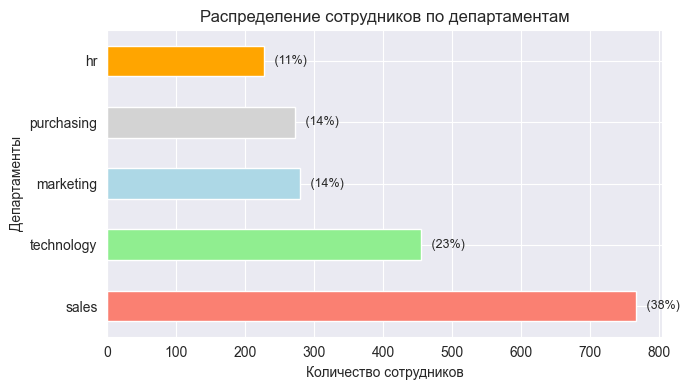

array(['marketing', 'hr', 'sales', 'purchasing', 'technology'],
      dtype=object)

In [68]:
create_barh(test_features.dept.value_counts(), 'Количество сотрудников', 'Департаменты',
            'Распределение сотрудников по департаментам')
test_features.dept.unique()

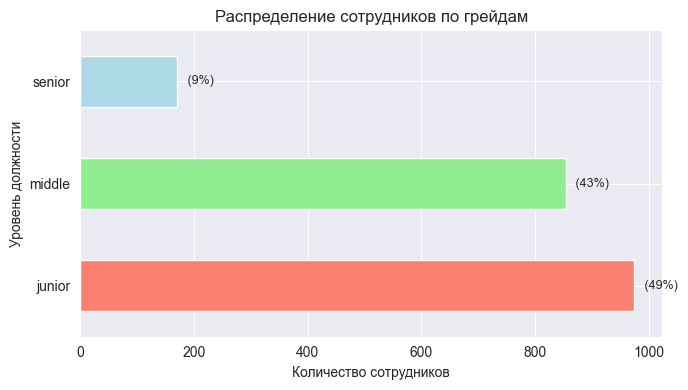

array(['junior', 'middle', 'senior'], dtype=object)

In [69]:
create_barh(test_features.level.value_counts(), 'Количество сотрудников', 'Уровень должности', 
            'Распределение сотрудников по грейдам')
test_features.level.unique()

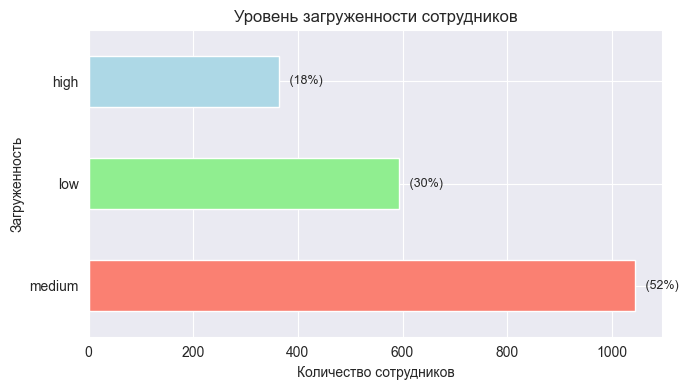

array(['medium', 'low', 'high'], dtype=object)

In [70]:
create_barh(test_features.workload.value_counts(), 'Количество сотрудников', 'Загруженность',
            'Уровень загруженности сотрудников')
test_features.workload.unique()

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/308338361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend = False)


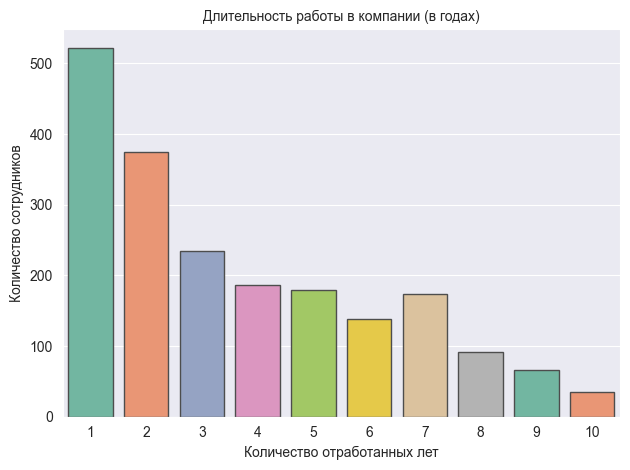

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

In [71]:
creat_plot_views(test_features.employment_years, 'Количество отработанных лет', 
            'Длительность работы в компании (в годах)')
test_features.employment_years.unique()

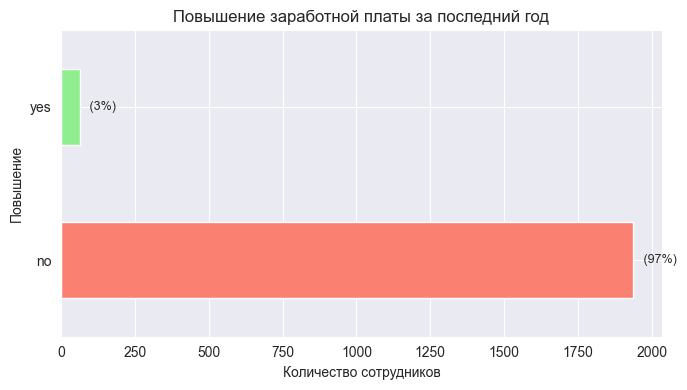

array(['no', 'yes'], dtype=object)

In [72]:
create_barh(test_features.last_year_promo.value_counts(),'Количество сотрудников', 'Повышение',
            'Повышение заработной платы за последний год')
test_features.last_year_promo.unique()

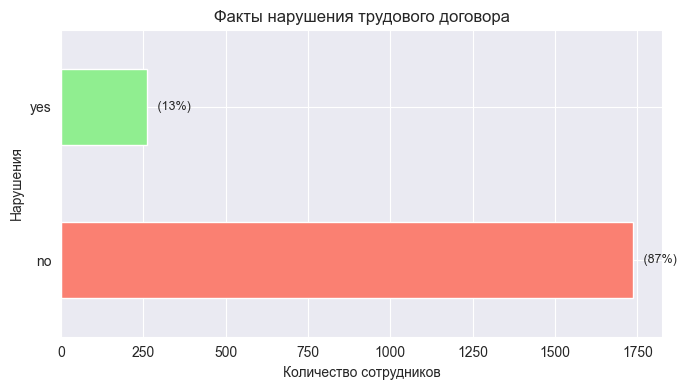

array(['no', 'yes'], dtype=object)

In [73]:
create_barh(test_features.last_year_violations.value_counts(),'Количество сотрудников', 'Нарушения',
            'Факты нарушения трудового договора')
test_features.last_year_violations.unique()

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/308338361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend = False)


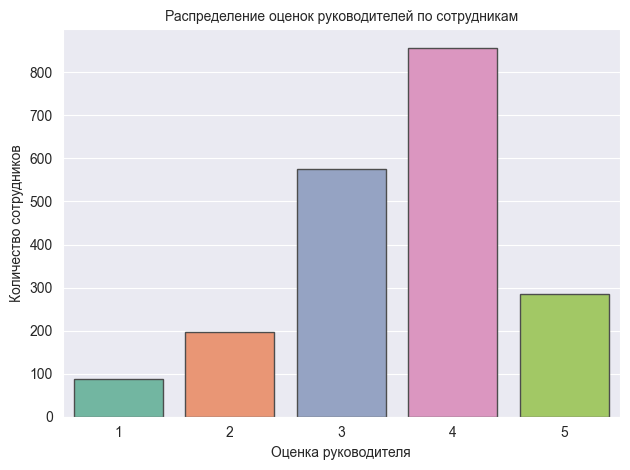

array([5, 4, 3, 1, 2])

In [74]:
creat_plot_views(test_features.supervisor_evaluation, 'Оценка руководителя', 
            'Распределение оценок руководителей по сотрудникам')
test_features.supervisor_evaluation.unique()

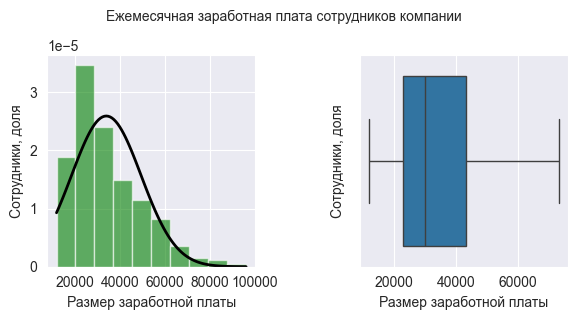

In [75]:
create_plots(test_features.salary, 'Размер заработной платы','Cотрудники, доля',
             'Ежемесячная заработная плата сотрудников компании')

In [76]:
# построим матрицу корреляции phik
data_types = {'dept':'categorical',
              'level':'categorical',
              'workload':'categorical',
              'employment_years': 'discrete',
              'last_year_promo':'categorical',
              'last_year_violations':'categorical',
             'supervisor_evaluation':'discrete',
              'salary' :'interval',
              'job_satisfaction_rate':'interval'}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in train_job.columns]

In [77]:
# удалим столбец 'id', превратив его в индекс, чтобы убрать его из признаков
X_train_job_all = train_job.set_index('id').copy()
X_test_job= test_features.set_index('id').copy()
y_test_job = target_job_satisfaction.set_index('id').copy()

In [78]:
сorrelation_matrix = X_train_job_all.phik_matrix(interval_cols=interval_cols, bins = 5)
display(сorrelation_matrix)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016542,0.036815,0.000000,0.000000,0.105706,0.271861,0.080480
level,0.000000,1.000000,0.419591,0.682962,0.101668,0.000000,0.000000,0.594165,0.054115
workload,0.016542,0.419591,1.000000,0.181941,0.058663,0.000000,0.037023,0.613955,0.028801
employment_years,0.036815,0.682962,0.181941,1.000000,0.183579,0.056808,0.000000,0.495307,0.337103
last_year_promo,0.000000,0.101668,0.058663,0.183579,1.000000,0.000000,0.013681,0.129184,0.094414
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.008618,0.336863
supervisor_evaluation,0.105706,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.040802,0.794519
salary,0.271861,0.594165,0.613955,0.495307,0.129184,0.008618,0.040802,1.000000,0.129237
job_satisfaction_rate,0.080480,0.054115,0.028801,0.337103,0.094414,0.336863,0.794519,0.129237,1.000000


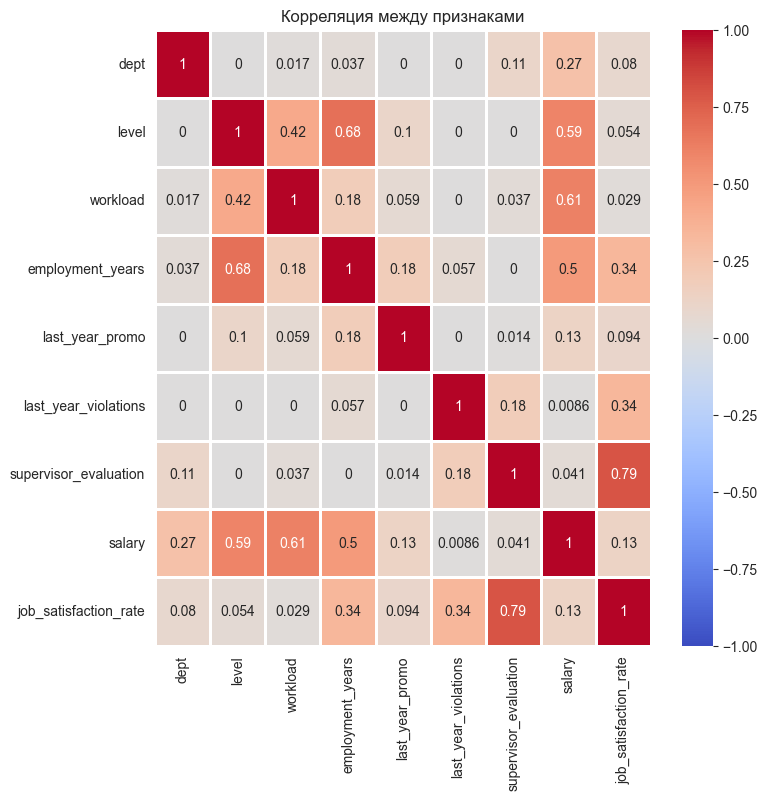

In [79]:
fig = plt.figure(figsize=(8, 8)) 
sns.heatmap(сorrelation_matrix, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = -1, center = 0, linewidths = 2)
plt.title('Корреляция между признаками')
plt.show()

Согласно матрице корреляции phik, есть высокая корреляция между целевым признаком job_satisfaction_rate с supervisor_evaluation и низкая корреляция с workload, level и dept. Мультиколлинеарности между признаками не выявлено.

### Выводы по исследовательскому анализу данных
1. Исследование признаков в датасетах:
  - Признак dept, категориальный признак, 5 категорий, наибольший вес занимает категория sales (32%). Низкая корреляция с таргетом.
  - level, категориальный ранговый признак, 3 категории, наибольший вес занимает категория junior (47%). Низкая корреляция с таргетом.
  - workload, категориальный ранговый признак, 3 категории, наибольший вес занимает категория medium (52%). Низкая корреляция с таргетом.
  - employment_years', количественный дискретный признак. В компании преобладают сотрудники со стажем работы 1–2 года. Умеренная корреляция с таргетом, возможно, имеет смысл перевести признак в категориальную шкалу.
  - last_year_promo, бинарный категориальный признак, преобладающее значение no (97%). Судя по подобному распределению, в компании отсутствует ежегодная индексация заработной платы.
  - last_year_violations', бинарный категориальный признак, преобладающее значение no (86%). На мой взгляд, показатель, что 14% сотрудников нарушали трудовой договор за прошлый год, это слишком много. Либо в компании жесткая система штрафов, либо найм низкоквалифицированного и низкомотивированного персонала. Умеренная корреляция с целевым признаком.
  - supervisor_evaluation', количественный дискретный признак, наиболее распространенные оценки руководителей 3 и 4. Высокая корреляция с таргетом.
  - salary', количественный признак. Средняя заработная плата 33927, min 12000, max 98400. Выбросов нет, в датасете объединены сотрудники различных грейдов.
  - job_satisfaction_rate', количественный целевой признак. Средний уровень 0.53, min 0.03, max 1. Выбросов нет.
  - Данные в датасетах train_job и test_features распределены практически одинаково, каких-либо существенных различий в распределении данных нет

2. Выбраны следующие кодировщики для данных:
OneHotEncoder: dept (признаки неупорядочены).
OrdinalEncoder: level (ранговый), workload (ранговый), last_year_promo, last_year_violations (бинарные, чтобы не раздувать значения + будем использовать древесную модель).
MinMaxScaler(), StandardScaler() для employment_years, supervisor_evaluation, salary.

## 1.4. Подготовка данных

Принято решение обучать модель на датасете X_train_job_all, а затем проверить работу модели на датасетах X_test_job и y_test_job

In [90]:
RANDOM_STATE = 72
TEST_SIZE = 0.3
X_train_job = X_train_job_all.drop(['job_satisfaction_rate'], axis= 1)
y_train_job= X_train_job_all['job_satisfaction_rate']


X_train_job.shape, X_test_job.shape, y_train_job.shape, y_test_job.shape

((4000, 8), (2000, 8), (4000,), (2000, 1))

In [94]:
ohe_columns = [
    'dept',     
    'last_year_promo', 
    'last_year_violations'
]

ord_columns = [
    'level', 
    'workload'
]
num_columns = ['employment_years', 'supervisor_evaluation', 'salary'] 

In [95]:
# OHE
ohe_pipe = Pipeline(
    [
        ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [96]:
# ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'hight']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [97]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)    

### Выводы по подготовке данных:
- было принято решение обучить модель на датасете X_train_job_all, а затем осуществить проверку работы модели на датасетах X_test_job и y_test_job;
- была выполнена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки;
- был создан общий пайплайн data_preprocessor для подготовки данных.

## 1.5. Обучение моделей

Необходимо создать новую метрику SMAPE (симметричное среднее абсолютное процентное отклонение)

In [102]:
# Создаем новую метрику SMAPE
def smape_metric(y_true, y_pred):
    """
    Вычисляет значение метрики SMAPE.

    :y_true: массив фактических значений (numpy array или pandas Series)
    :y_pred: массив предсказанных значений (numpy array или pandas Series)
    :return: значение SMAPE в процентах

    Примечание: 
    - SMAPE увеличивается с ухудшением качества модели.
    - Значение SMAPE ближе к 0% указывает на более хорошее качество прогноза.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred))/2
    diff = (np.abs(y_pred - y_true)) / denominator
    diff[denominator == 0] = 0.0  # Установка 0 для случаев, когда оба значения ноль

    return 100 * np.mean(diff)
    
# Создаём пользовательскую метрику
smape_score = make_scorer(smape_metric, greater_is_better=False)

In [104]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_job = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

# Создаем сетку гиперпараметров для множества моделей
param_grid_job = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 10),
        'models__n_estimators': range(10, 100),
        'models__num_leaves': range(10, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [105]:
# осуществим выборочный перебор значений гиперпараметров
rz_search_job = RandomizedSearchCV(
    pipe_final_job, 
    param_grid_job, 
    cv=20,
    scoring=smape_score,
    n_jobs=-1,
    random_state= RANDOM_STATE
)

In [106]:
# обучим модель на тренировочных данных
rz_search_job.fit(X_train_job, y_train_job)
print('Лучшая модель и её параметры:\n\n', rz_search_job.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации на обучающей выборке:', rz_search_job.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [107]:
# посмотрим данные остальных моделей
result = pd.DataFrame(rz_search_job.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
6,1,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-12.389798,"{'preprocessor__num': 'passthrough', 'models__..."
2,2,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-12.754941,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,3,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-12.899527,"{'preprocessor__num': 'passthrough', 'models__..."
0,4,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-13.417760,"{'preprocessor__num': 'passthrough', 'models__..."
5,5,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-13.610080,"{'preprocessor__num': StandardScaler(), 'model..."
9,6,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-15.298215,"{'preprocessor__num': 'passthrough', 'models__..."
8,7,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-16.013268,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,8,DecisionTreeRegressor(random_state=72),-16.772578,"{'preprocessor__num': StandardScaler(), 'model..."
4,9,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-16.850024,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,10,"LGBMRegressor(n_jobs=-1, random_state=72, verb...",-21.307984,"{'preprocessor__num': 'passthrough', 'models__..."


In [108]:
# изменим гиперпараметры лучшей модели, чтобы подобрать решение.
pipe_final_job_best = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_job_best = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 7),
        'models__n_estimators': range(90, 150),
        'models__num_leaves': range(10, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
]

rz_search_job_best = RandomizedSearchCV(
    pipe_final_job_best, 
    param_grid_job_best, 
    cv=20,
    scoring=smape_score,
    n_jobs=-1,
    random_state= RANDOM_STATE
)

rz_search_job_best.fit(X_train_job, y_train_job)
print('Лучшая модель и её параметры:\n\n', rz_search_job_best.best_estimator_)
print ('Метрика лучшей модели с гиперпараметрами на обучающей выборке:', rz_search_job_best.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [109]:
# объединим тестовый датасет и таргет в единый датасет, так как параметры и ID не совпадают
test_full = X_test_job.merge(y_test_job, right_index=True, left_index=True)
test_full.sample()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
634763,sales,middle,low,7,no,no,4,19200,0.64


In [110]:
# выделим тестовую выборку и целевой признак в объединённом датасете.
X_test = test_full.drop(['job_satisfaction_rate'], axis = 1)
y_test= test_full['job_satisfaction_rate']

In [111]:
y_test_pred = rz_search_job_best.predict(X_test)
y_test_smape = smape_metric(y_test, y_test_pred)
print ('Метрика лучшей модели на тестовой выборке:', y_test_smape)

Метрика лучшей модели на тестовой выборке: 11.525018967729658


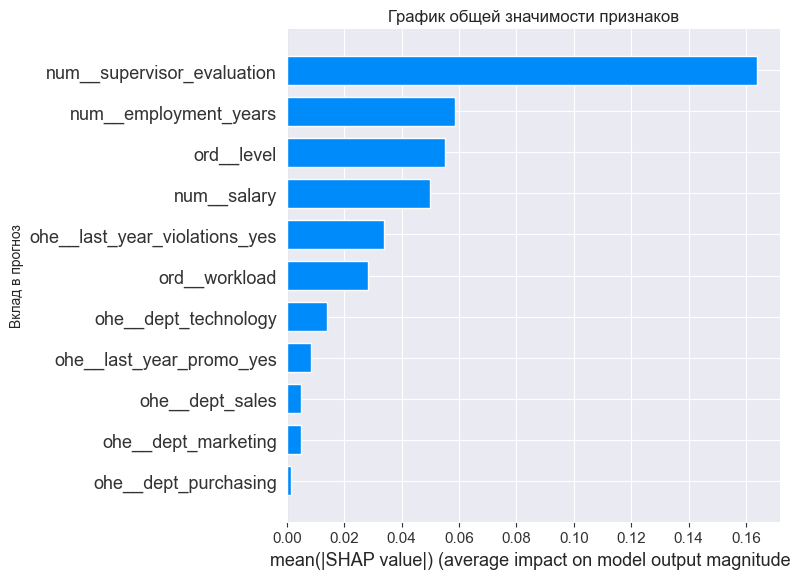

None

In [112]:
# построим график общей значимости признаков, для наблюдения возьмем тестовоую выборку
preprocessor_pipe = rz_search_job_best.best_estimator_.named_steps['preprocessor']
X_test_scalled = preprocessor_pipe.transform(X_test)
feature_names = rz_search_job_best.best_estimator_[:-1].get_feature_names_out()

# Создаем Explainer
explainer = shap.TreeExplainer(rz_search_job_best.best_estimator_['models'])

# Получаем SHAP-значения для данных
shap_values = explainer.shap_values(X_test_scalled)

plt.figure(figsize=(6, 4)) 
plt.xlabel("Признаки")
plt.ylabel("Вклад в прогноз") 
plt.title('График общей значимости признаков')
plt.rcParams["font.size"] = 10
display(shap.summary_plot(shap_values, X_test_scalled, feature_names=feature_names, plot_type="bar"))

### Выводы по этапу обучения моделей
1. Была создана пользовательская метрика SMAPE (симметричное среднее абсолютное процентное отклонение), которая учитывалась при оценке моделей;
2. Был создан пайплайн с тремя моделями: DecisionTreeRegressor, LGBMRegressor, LogisticRegression для поиска лучшей модели;
3. По итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMRegressor с параметрами (max_depth=6, n_estimators=95, n_jobs=-1, num_leaves=22, random_state=72, verbose=-1). Метрика на обучающей выборке -12.38,  на тестовой — 11.52;
4. Второе место занимает модель LGBMRegressor c параметрами (num_leaves': 22, 'models__n_estimators': 95, 'models__max_depth': 6) и на третьем месте LGBMRegressor c параметрами (num_leaves': 21, 'models__n_estimators': 95, 'models__max_depth': 6);
5. Методом RandomizedSearchCV были подобраны новые гиперпараметры лучшей модели, новые параметры LGBMRegressor(max_depth=6, n_estimators=128, n_jobs=-1, num_leaves=19, random_state=72, verbose=-1);
Метрика лучшей модели с гиперпараметрами на обучающей выборке: 12.09;
6. Был создан датасет, который объединил 2 датасета с тестовыми данными и целевым признаком;
7. Был построен график общей значимости признаков. Модель посчитала наиболее значимыми признаки, которые влияют на удовлетворение сотрудников: оценка руководителя, время работы в компании, грейд должности. Наименее значимые признаки — это департамент, в котором работает сотрудник.
То есть для сотрудников компании в первую очередь важно признание своих заслуг со стороны руководителя, лояльность к компании, а во вторую очередь уже финансовая составляющая.

## 1.6. Промежуточные итоги по задаче

По итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMRegressor с параметрами (max_depth=6, n_estimators=95, n_jobs=-1, num_leaves=19, random_state=72, verbose=-1). Метрика на тестовой — 11.52;

Модель LGBMRegressor показала лучшие результаты по следующим причинам:
* LGBMRegressor может выявлять сложные нелинейные зависимости между признаками и целевой переменной. Даже если корреляция между признаками и целевой переменной низкая, модель может обнаруживать скрытые закономерности.
* Модель может учесть взаимодействия между признаками, что позволяет улучшить качество прогнозирования. Это особенно полезно, когда отдельные переменные имеют низкую корреляцию, но их комбинация может быть значимой.
* LGBMRegressor не предполагает конкретной формы функции зависимости между признаками и целевой переменной. Это позволяет модели адаптироваться к данным, даже если они не подчиняются классическим статистическим предположениям о линейности.

# Задача №2: предсказание увольнения сотрудника из компании. 

## 2.1. Изучение общей информации о датасетах

In [121]:
train_quit = load_data('/Users/gulnaravolodina/Documents/train_quit.csv', 
                 'https://code.s3.yandex.net/datasets/train_quit.csv')

Ошибка при загрузке данных из локального файла: [Errno 1] Operation not permitted: '/Users/gulnaravolodina/Documents/train_quit.csv'
Данные успешно загружены из URL.


In [122]:
get_data_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1628,744363,marketing,middle,high,8,no,no,4,52800,no
2158,879368,marketing,middle,medium,4,yes,no,3,36000,no
2655,741067,purchasing,junior,low,2,no,no,5,15600,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000000,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.283750,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,260158.031387,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,327785.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,546673.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,781497.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


'Количество явных дубликатов:'

0

In [123]:
target_quit = load_data('/Users/gulnaravolodina/Documents/test_target_quit.csv', 
                 'https://code.s3.yandex.net/datasets/test_target_quit.csv')

Ошибка при загрузке данных из локального файла: [Errno 1] Operation not permitted: '/Users/gulnaravolodina/Documents/test_target_quit.csv'
Данные успешно загружены из URL.


In [124]:
get_data_info(target_quit)

,id,quit
401,647024,yes
1589,477983,no
1929,377264,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,quit
count,2000.000000,2000
unique,NaN,2
top,NaN,no
freq,NaN,1436
mean,552765.213500,NaN
std,253851.326129,NaN
min,100298.000000,NaN
25%,339052.000000,NaN
50%,550793.000000,NaN
75%,765763.750000,NaN


'Количество явных дубликатов:'

0

### Выводы по первому этапу:
Получено 2 датасета:
* train_quit, состоящий из 4000 строк;
* target_quit, состоящий из 2000 строк.
В датасетах явные дубликаты отсутствуют, в данных пропусков нет, данных достаточно для анализа.

## 2.2. Предобработка данных

In [127]:
# заменим опечатку в данных
train_quit['level'] = train_quit['level'].str.replace('sinior','senior')

In [128]:
# проверим уникальные значения в датасете
[{i: list(train_quit[i].unique())} for i in train_quit.columns if train_quit[i].dtype == 'object']

[{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr']},
 {'level': ['middle', 'junior', 'senior']},
 {'workload': ['high', 'medium', 'low']},
 {'last_year_promo': ['no', 'yes']},
 {'last_year_violations': ['no', 'yes']},
 {'quit': ['no', 'yes']}]

### Выводы по этапу предобработке данных:
* была заменена опечатка в датасете train_quit
* датасет test_features был предобработан в рамках первой задачи

## 2.3. Исследовательский анализ данных

### 2.3.1. Исследование полученных данных.

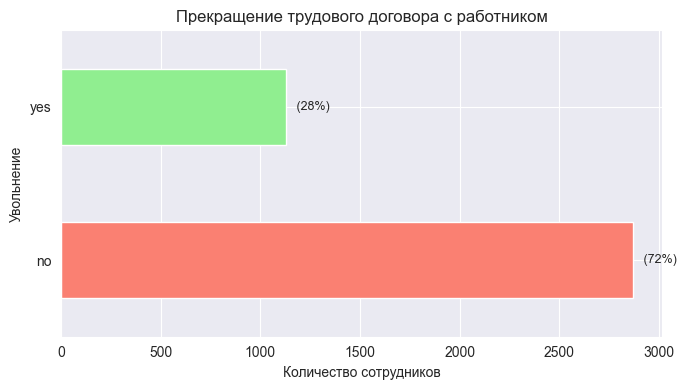

array(['no', 'yes'], dtype=object)

In [132]:
# посмотрим на распределение новых данных по всем сотрудникам:
create_barh(train_quit.quit.value_counts(),'Количество сотрудников', 'Увольнение',
            'Прекращение трудового договора с работником')
train_quit.last_year_violations.unique()

Текучесть в компании 28% за предоставленный период

In [134]:
# отберем всех уволившихся работников
free = train_quit[train_quit['quit'] == 'yes']
free.shape

(1128, 10)

In [135]:
# создадим функцию, которая будет отображать сразу 2 графика
def create_double_pie(data1, data2, title1, title2):
    sns.set_style("darkgrid")
    
    # Создаем фигуру и оси для двух круговых диаграмм
    fig, axs = plt.subplots(1, 2, figsize=(10, 7)) 

    # Первая круговая диаграмма
    total1 = sum(data1)  
    wedges1, texts1, autotexts1 = axs[0].pie(data1, labels=data1.index, autopct='%1.1f%%', 
                                             startangle=90, colors=sns.color_palette("pastel", len(data1)))
    
    for t in autotexts1:
        t.set_size(10)
        t.set_color('black')
        
    axs[0].set_title(title1, fontsize=12)

    # Вторая круговая диаграмма
    total2 = sum(data2)  #
    wedges2, texts2, autotexts2 = axs[1].pie(data2, labels=data2.index, autopct='%1.1f%%', 
                                             startangle=90, colors=sns.color_palette("pastel", len(data2)))
    
    for t in autotexts2:
        t.set_size(10)
        t.set_color('black')
        
    axs[1].set_title(title2, fontsize=12)

    plt.tight_layout()
    plt.show()

In [136]:
# создадим функцию, которая будет отображать сразу 2 графика
def creat_2plot_views(data1, data2, xname, title):
    sns.set_style("darkgrid")
    
    # Построение первого графика
    sns.countplot(x=data1, color='blue', alpha=0.5, edgecolor=".3", linewidth=1, legend=False, label='Все сотрудники')
    
    # Построение второго графика (наложение на первый)
    sns.countplot(x=data2, color='orange', alpha=0.5, edgecolor=".3", linewidth=1, legend=False, label='Уволенные сотрудники')
    
    plt.xlabel(xname)
    plt.ylabel('Количество сотрудников')
    plt.title(title, fontsize=10)
    plt.legend(title='Данные по сотрудникам', loc='upper right') 
    plt.tight_layout()
    plt.show()

In [137]:
def calculate_shares(df_all, df_free, column):

    all_count = train_quit[column].value_counts()
    free_count = free[column].value_counts()

    for i in free_count.index:
        free_count[i] /= all_count[i]

    return free_count*100

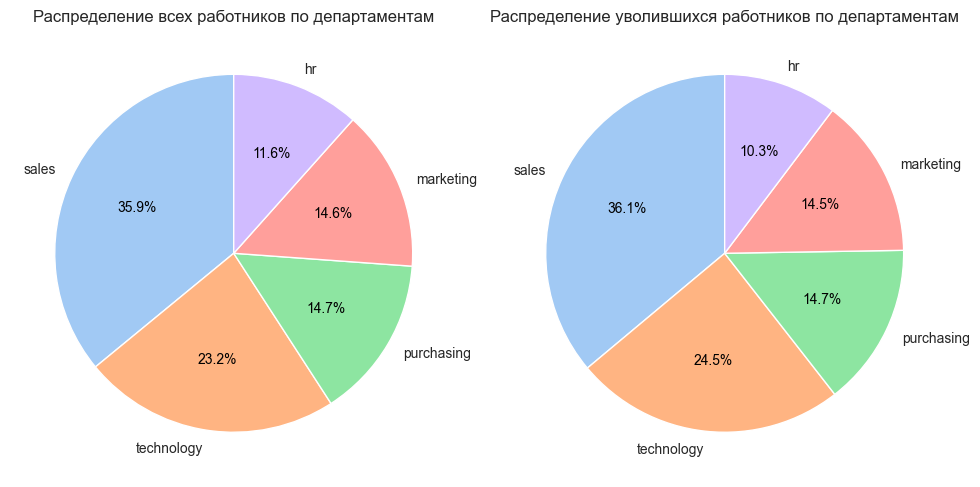

In [138]:
create_double_pie(train_quit.dept.value_counts(), free.dept.value_counts(), 'Распределение всех работников по департаментам', 
                  'Распределение уволившихся работников по департаментам')

In [139]:
# посмотрим долю, среди уволившихся
calculate_shares(train_quit, free, 'dept')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28303198887343534' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


dept
sales         28.303199
technology    29.741379
purchasing    28.231293
marketing     28.006873
hr            25.000000
Name: count, dtype: float64

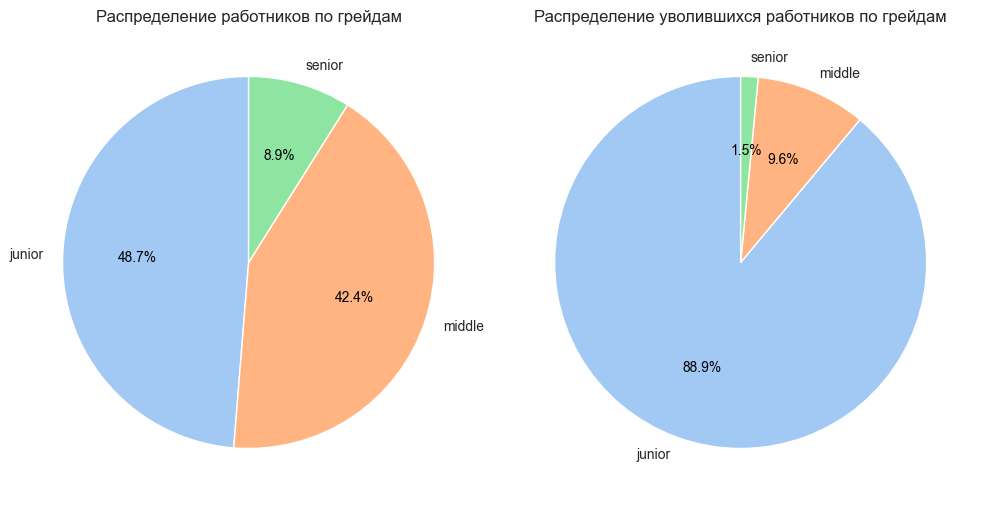

In [140]:
create_double_pie(train_quit.level.value_counts(), free.level.value_counts(),
                  'Распределение работников по грейдам', 'Распределение уволившихся работников по грейдам')

In [141]:
calculate_shares(train_quit, free, 'level')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5146228835300154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


level
junior    51.462288
middle     6.375443
senior     4.761905
Name: count, dtype: float64

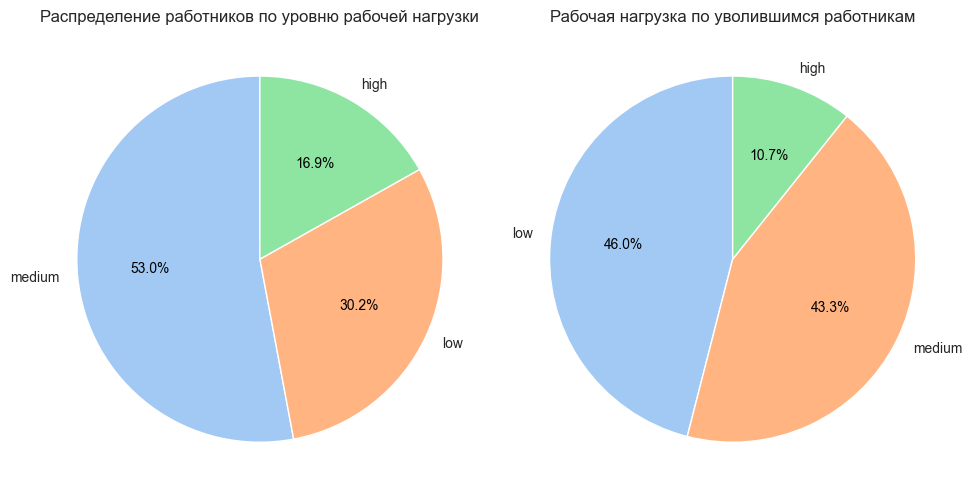

In [142]:
create_double_pie(train_quit.workload.value_counts(),free.workload.value_counts(),
                  'Распределение работников по уровню рабочей нагрузки', 'Рабочая нагрузка по уволившимся работникам')

In [143]:
calculate_shares(train_quit, free, 'workload')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.429635761589404' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


workload
low       42.963576
medium    23.040604
high      17.952522
Name: count, dtype: float64

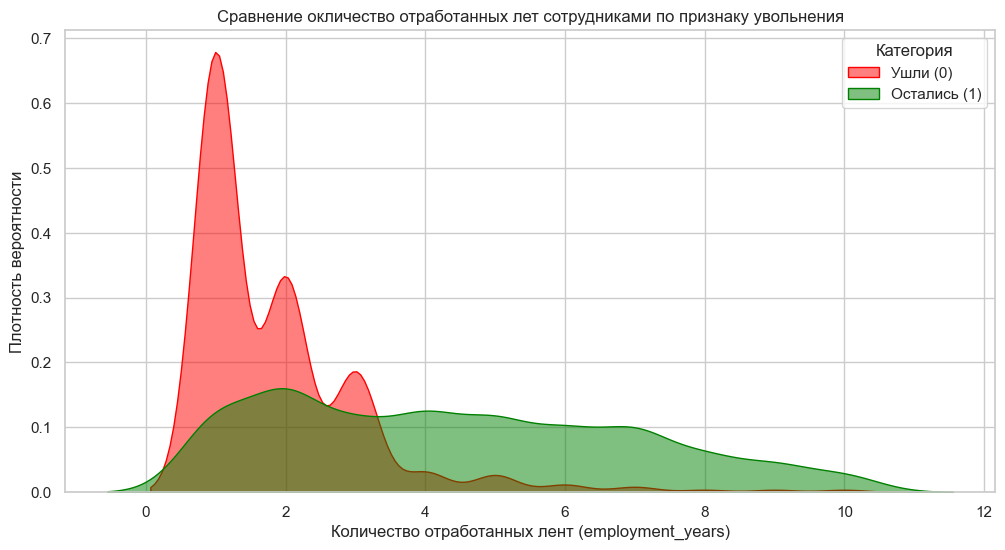

In [144]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# распределение для ушедших сотрудников
sns.kdeplot(data=train_quit, x='employment_years', hue='quit', common_norm=False, fill=True,
             palette={'no': 'green', 'yes': 'red'}, alpha=0.5)


plt.title('Сравнение окличество отработанных лет сотрудниками по признаку увольнения')
plt.xlabel('Количество отработанных лент (employment_years)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Категория', labels=['Ушли (0)', 'Остались (1)'])
plt.show()

In [145]:
calculate_shares(train_quit, free, 'employment_years')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6081218274111675' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


employment_years
1     60.812183
2     37.323037
3     34.029228
4      6.870229
5      6.353591
6      3.378378
7      2.272727
10     3.333333
8      1.724138
9      2.205882
Name: count, dtype: float64

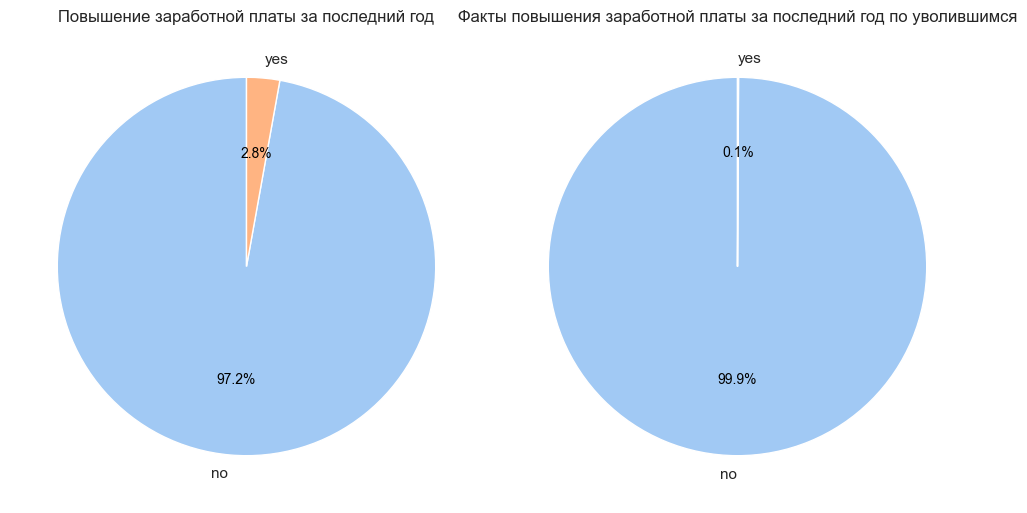

In [146]:
create_double_pie(train_quit.last_year_promo.value_counts(),free.last_year_promo.value_counts(),
                  'Повышение заработной платы за последний год', 'Факты повышения заработной платы за последний год по уволившимся')

In [147]:
calculate_shares(train_quit, free, 'last_year_promo')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.28994082840236685' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


last_year_promo
no     28.994083
yes     0.884956
Name: count, dtype: float64

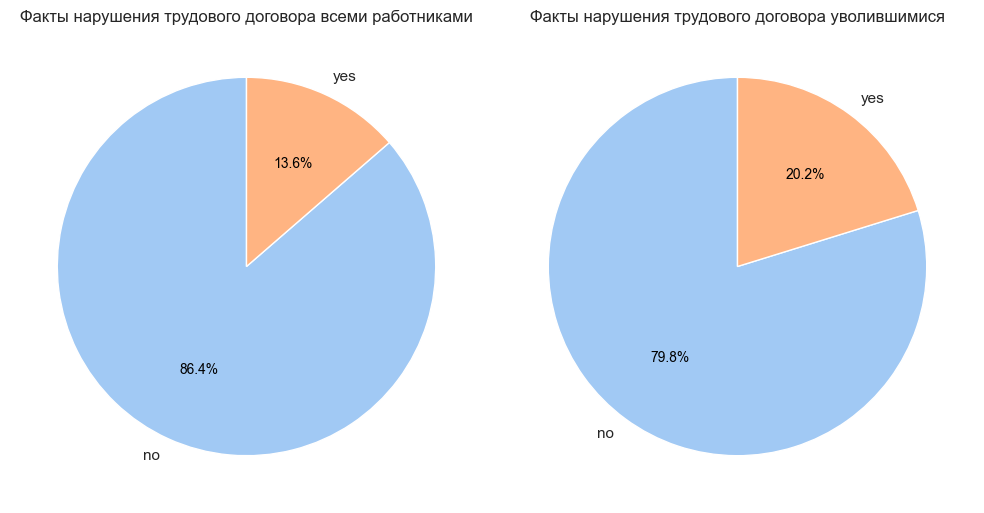

In [148]:
create_double_pie(train_quit.last_year_violations.value_counts(), free.last_year_violations.value_counts(), 
           'Факты нарушения трудового договора всеми работниками', 'Факты нарушения трудового договора уволившимися')

In [149]:
calculate_shares(train_quit, free, 'last_year_violations')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.26049204052098407' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


last_year_violations
no     26.049204
yes    41.834862
Name: count, dtype: float64

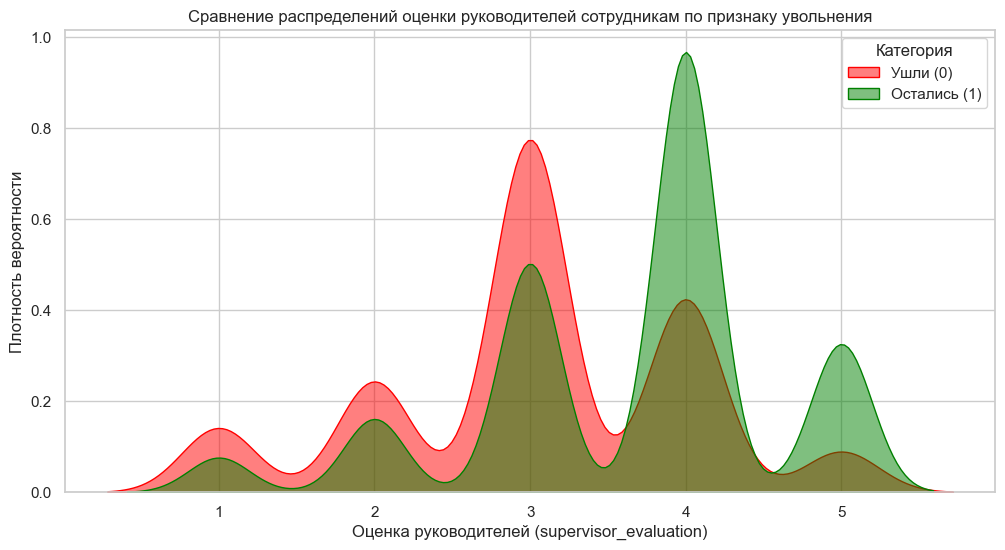

In [150]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# распределение для ушедших сотрудников
sns.kdeplot(data=train_quit, x='supervisor_evaluation', hue='quit', common_norm=False, fill=True,
             palette={'no': 'green', 'yes': 'red'}, alpha=0.5)


plt.title('Сравнение распределений оценки руководителей сотрудникам по признаку увольнения')
plt.xlabel('Оценка руководителей (supervisor_evaluation)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Категория', labels=['Ушли (0)', 'Остались (1)'])
plt.show()

In [151]:
calculate_shares(train_quit, free, 'supervisor_evaluation')

/var/folders/d9/tg9rb_195q58897zh740mgrr0000gn/T/ipykernel_55953/603738189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.42416869424168696' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  free_count[i] /= all_count[i]


supervisor_evaluation
3    42.416869
4    17.291415
2    41.943734
1    47.029703
5    11.538462
Name: count, dtype: float64

### 2.3.2. Составление портрета уволившегося работника

Давайте составим портрет сотрудника, который уволился:

1. С наибольшей вероятностью этот человек работал в одном из двух отделов: в Департаменте продаж (28,3% доля всех уволенных от числа работающих) или в Департаменте технологий (29,7% доля всех уволенных сотрудников).
2. Текучесть кадров в основном наблюдается среди младших специалистов (51% от всех работников данного уровня были уволены).
3. Эти сотрудники были либо недостаточно загружены работой (42% от всех сотрудников с полобной нагрузкой были уволены), либо работали в среднем темпе.
4. Большинство увольнений происходит в первые два года работы в компании, что объясняет значительное количество сотрудников с опытом работы 1–2 года — они приходят на замену тем, кто уволился. 61% из тех, кто устроился в первый же год, были уволены.
5. За время работы практически никому из уволившихся не была повышена заработная плата. Похоже, что даже на испытательном сроке сотрудники получают полную ставку без возможности продвижения по карьерной лестнице.
6. Большинство увольнений происходило по собственному желанию (80%), однако 41% сотрудников из всех, кто получил взыскание, уволились.
7. Среди уволившихся больше всего сотрудников получили оценку «3» от своего руководителя. Свыше 40% работников, кто получил низкую оценку (1-3), уволились.

Я бы описала уволившегося сотрудника следующим образом: это молодой специалист, который только начинает свою карьеру в сфере продаж или IT. На работе он не получает достаточной нагрузки (возможно, ему пока не доверяют самостоятельные проекты), а по итогам отчетного периода (года?) получает невысокую оценку от своего руководителя, что окончательно демотивирует его и заставляет покинуть компанию.

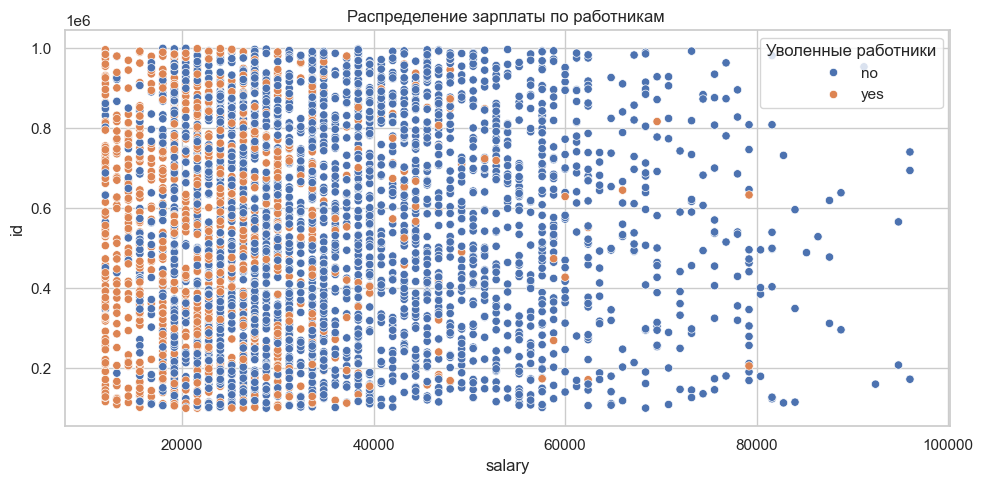

In [154]:
# посмотрим распределение заработной платы по работникам компании, включая уволенных
plt.figure(figsize = (10,5))
sns.scatterplot(data = train_quit, x = 'salary', y = 'id', hue = 'quit')
plt.title('Распределение зарплаты по работникам ')
plt.tight_layout()
plt.legend(title= 'Уволенные работники', loc = 'best')
plt.show()

Поскольку компания теряет в основном молодых специалистов, то у многих из них заработная плата составляет до 22 000 рублей. 

### 2.3.3. Поиск взаимосвязи между текучестью и уровнем удовлетворенности работника

In [160]:
# объеденим 2 датасета, чтобы посмотреть зависимости
find_corr = target_job_satisfaction.merge(target_quit, right_index=True, left_index=True)
find_corr = find_corr.drop(columns=['id_y'])
find_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_x                   2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
 2   quit                   2000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 47.0+ KB


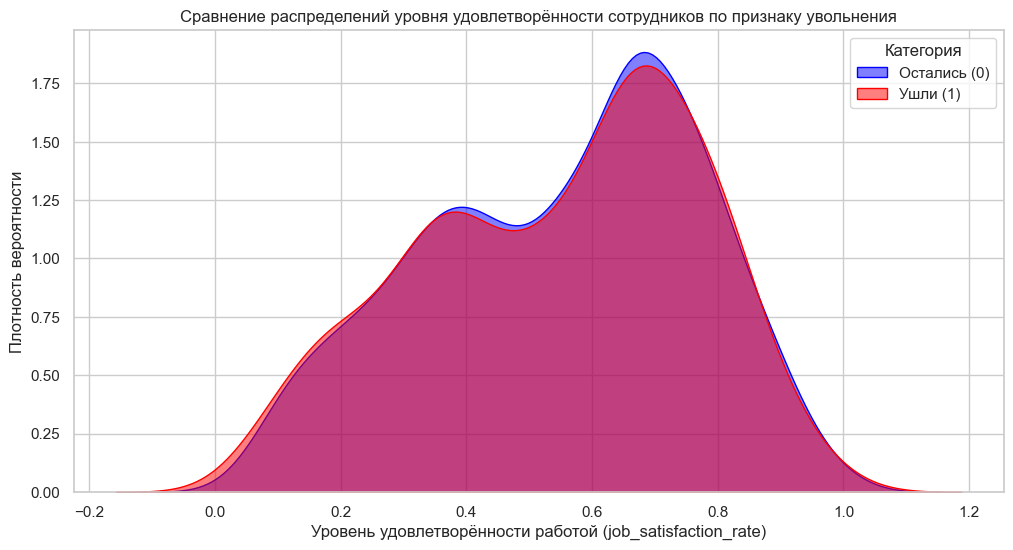

In [161]:
# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# распределение для ушедших сотрудников
sns.kdeplot(data=find_corr, x='job_satisfaction_rate', hue='quit', common_norm=False, fill=True,
             palette={'no': 'blue', 'yes': 'red'}, alpha=0.5)


plt.title('Сравнение распределений уровня удовлетворённости сотрудников по признаку увольнения')
plt.xlabel('Уровень удовлетворённости работой (job_satisfaction_rate)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Категория', labels=['Остались (0)', 'Ушли (1)'])
plt.show()

График показывает, большинство работников, показывающих низкий уровень удовлетворенности (0-0,2), числятся среди ушедших сотрудников, в то время как уровень удовлетворенности от 0,4 и выше показывают оставшиеся работники.
Таким образом аналитики оказались правы и уровень удовлетворенности действительно влияет на уход работника из компании

### Выводы по исследовательскому анализу данных:
- в предоставленных данных нет аномалий;
- была исправлена опечатка;
- основные характеристики уволившегося работника:
    1. работа в Департаменте продаж или в Департаменте технологий;
    2. младший уровень должности;
    3. недостаточная рабочая нагрузка, либо работали в среднем темпе;
    4. время работы в компании до двух лет;
    5. заработная плата не увеличивалась с момента приема на работу;
    6. уволился по собственному желанию;
    7. получил оценку «3» от своего руководителя по итогам отчетного периода;
    8. заработная плата до 22 000 рублей;
- выявлена взаимосвязь между уровнем удовлетворенности работников и текучестью персонала.

## 2.4. Добавление нового признака

In [166]:
# добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи к входным признакам второй задачи.
predictions_rate = rz_search_job_best.predict(train_quit)
corr_quit=train_quit.copy()
corr_quit['job_satisfaction_rate'] = predictions_rate
corr_quit.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
885,438610,sales,junior,low,1,no,no,4,15600,no,0.641930
2105,170187,sales,junior,medium,2,no,yes,2,20400,yes,0.183956
932,111922,technology,junior,medium,1,no,no,3,33600,yes,0.315028
3479,819709,sales,middle,high,7,no,yes,4,58800,no,0.661234
1687,505058,sales,middle,high,4,no,no,4,49200,no,0.509178


In [167]:
corr_quit = corr_quit.set_index('id').copy()

In [168]:
# посмотрим матрицу корреляции признаков
data_types_2 = {
              'dept':'categorical',
              'level':'categorical',
              'workload':'categorical',
              'employment_years': 'discrete',
              'last_year_promo':'categorical',
              'last_year_violations':'categorical',
             'supervisor_evaluation':'discrete',
              'salary' :'interval',
              'job_satisfaction_rate':'interval',
               'quit': 'categorical'
               }

interval_cols_2 = [col for col, v in data_types_2.items() if v=='interval' and col in corr_quit.columns]

сorrelation_matrix_2 = corr_quit.phik_matrix(interval_cols=interval_cols_2, bins = 5)
display(сorrelation_matrix_2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.240468,0.000000,0.098074
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.616707,0.312799,0.076366
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.607463,0.132243,0.066835
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.512893,0.659093,0.399616
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.122208,0.157370,0.102860
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.025583,0.185071,0.334354
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.036382,0.245489,0.813504
salary,0.240468,0.616707,0.607463,0.512893,0.122208,0.025583,0.036382,1.000000,0.322207,0.196706
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.322207,1.000000,0.328153
job_satisfaction_rate,0.098074,0.076366,0.066835,0.399616,0.102860,0.334354,0.813504,0.196706,0.328153,1.000000


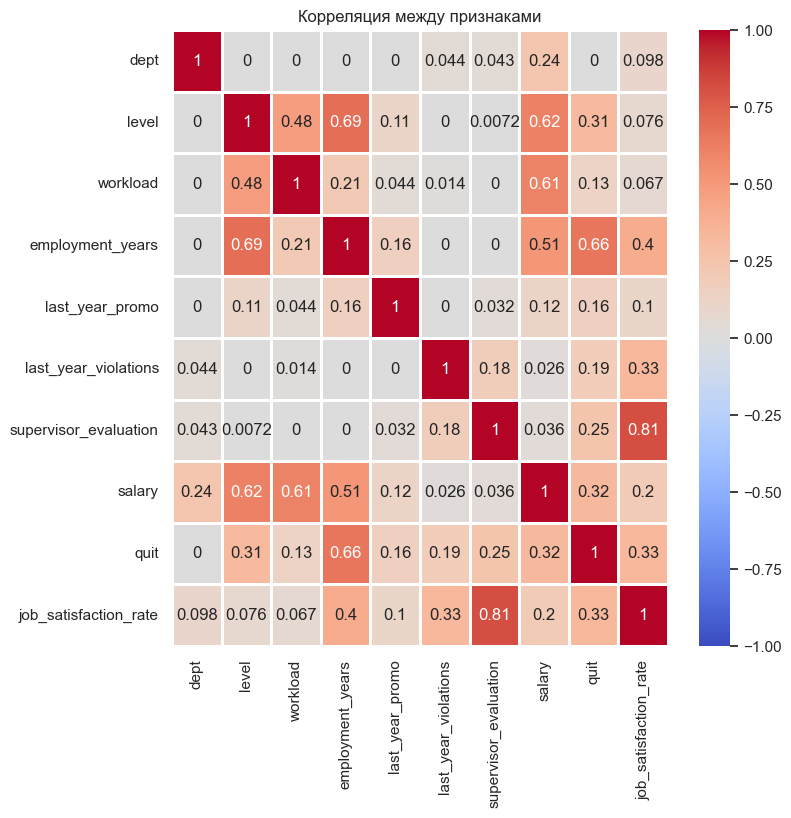

In [169]:
fig = plt.figure(figsize=(8, 8)) 
sns.heatmap(сorrelation_matrix_2, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = -1, center = 0, linewidths = 2)
plt.title('Корреляция между признаками')
plt.show()

Согласно матрице корреляции phik, есть высокая корреляция между целевым признаком quit и employment_years и отсутствие корреляции с dept. Мультиколлинеарности между признаками не выявлено.

### Выводы по этапу добавления нового признака:
- в датасет train_quit был добавлен новый признак job_satisfaction_rate_pred, полученный в результате предсказаний лучшей модели;
- была построена матрица корреляции, согласно матрице корреляции phik, есть высокая корреляция между целевым признаком quit и employment_years и отсутствие корреляции с dept. Мультиколлинеарности между признаками не выявлено.

## 2.5. Подготовка данных

Будем обучать модель на датасете X_train_quit, а затем проверим работу модели на датасетах X_test_quit и y_test_quit

In [175]:
X_train_quit = train_quit.set_index('id').copy()
X_test_quit = test_features.set_index('id').copy()
y_test_quit = target_quit.set_index('id').copy()

In [176]:
X_train_quit_2 = X_train_quit.drop(['quit'], axis= 1)
y_train_quit= X_train_quit['quit']

In [177]:
test_all_quit = X_test_quit.merge(y_test_quit, right_index=True, left_index=True)
test_all_quit.shape

(2000, 9)

In [178]:
test_all_quit['job_satisfaction_rate']= y_test_pred
X_test_quit_2 = test_all_quit.drop(['quit'], axis = 1)
y_test_quit_2= test_all_quit['quit']

In [179]:
le = LabelEncoder()
y_train_cod = le.fit_transform(y_train_quit)
y_test_cod = le.transform(y_test_quit_2)

In [181]:
X_train_quit_2['job_satisfaction_rate'] = rz_search_job_best.predict(X_train_quit_2)

In [182]:
X_train_quit_2.shape, X_test_quit_2.shape, y_train_cod.shape, y_test_cod.shape

((4000, 9), (2000, 9), (4000,), (2000,))

In [183]:
ohe_columns = [
    'dept',     
    'last_year_promo', 
    'last_year_violations'
]

ord_columns = [
    'level', 
    'workload'
]
num_columns_quit = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

In [184]:
# OHE
ohe_pipe = Pipeline(
    [
        ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [185]:
# ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'hight']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [186]:
# создаём общий пайплайн для подготовки данных
data_preprocessor_quit = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
)    

### Выводы по этапу подготовки данных:
- Было принято решение обучить модель на датасете X_train_quit, а затем осуществить проверку работы модели на датасетах X_test_quit и y_test_quit;
- до разделения данных целевой признак quit был закодирован;
- была выполнена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки;
- был создан общий пайплайн data_preprocessor_quit для подготовки данных.

## 2.6. Обучение модели

In [189]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_quit = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')],
        'models__penalty': ['l1'],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_leaf': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 10),
        'models__n_estimators': range(80, 120),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]


In [190]:
# осуществим выборочный перебор значений гиперпараметров
rz_search_quit = RandomizedSearchCV(
        pipe_final_quit,
        param_grid_quit,
        n_jobs=-1,
        cv=10,
        n_iter=20,
        scoring='roc_auc',
        random_state=RANDOM_STATE
)

In [191]:
# обучим модель на тренировочных данных
rz_search_quit.fit(X_train_quit_2, y_train_cod)
print('Лучшая модель и её параметры:\n\n', rz_search_quit.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации на обучающей выборке:', rz_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [192]:
# посмотрим данные остальных моделей
result = pd.DataFrame(rz_search_quit.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
6,1,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938856,"{'preprocessor__num': 'passthrough', 'models__..."
13,2,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938688,"{'preprocessor__num': StandardScaler(), 'model..."
7,3,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938567,"{'preprocessor__num': 'passthrough', 'models__..."
5,4,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938379,"{'preprocessor__num': MinMaxScaler(), 'models_..."
17,5,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938311,"{'preprocessor__num': 'passthrough', 'models__..."
15,6,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938254,"{'preprocessor__num': 'passthrough', 'models__..."
18,7,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.938066,"{'preprocessor__num': 'passthrough', 'models__..."
2,8,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.937524,"{'preprocessor__num': MinMaxScaler(), 'models_..."
11,9,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.936989,"{'preprocessor__num': StandardScaler(), 'model..."
10,10,"LGBMClassifier(n_jobs=-1, random_state=72, ver...",0.936557,"{'preprocessor__num': 'passthrough', 'models__..."


In [193]:
# проверим работу модели на валидационной выборке
y_test_proba = rz_search_quit.predict_proba(X_test_quit_2)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_cod, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.93


### Выводы по этапу обучения модели:

1. Был создан пайплайн с четырьмя моделями: KNeighborsClassifier, LGBMClassifier, LogisticRegression, DecisionTreeClassifier для поиска лучшей модели;
2. По итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMClassifier( с параметрами (max_depth=2, n_estimators=99, n_jobs=-1, random_state=72, verbose=-1). Метрика на обучающей выборке -0.93, на тестовой — 0.93;

## 2.7. Промежуточные итоги по задаче

1. Был создан пайплайн с четырьмя моделями: KNeighborsClassifier, LGBMClassifier, LogisticRegression, DecisionTreeClassifier для поиска лучшей модели;
2. По итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMClassifier( с параметрами (max_depth=2, n_estimators=99, n_jobs=-1, random_state=72, verbose=-1). Метрика на обучающей выборке -0.93, на тестовой — 0.93
   Модель LGBMClassifier показала лучшие результаты по следующим причинам:
* LGBMClassifier может выявлять сложные нелинейные зависимости между признаками и целевой переменной. Даже если корреляция между признаками и целевой переменной низкая, модель может обнаруживать скрытые закономерности.
* Модель может учесть взаимодействия между признаками, что позволяет улучшить качество прогнозирования. Это особенно полезно, когда отдельные переменные имеют низкую корреляцию, но их комбинация может быть значимой.

# Общий вывод

Было поставлено 2 задачи:
1. Предсказать уровень удовлетворенности сотрудника;
2. Предсказать факт увольнения работника.
   
В рамках первой задачи была проделана следующая работа:
1. Было получено 3 датасета:
- train_job, состоящий из 4000 строк;
- test_features, состоящий из 2000 строк, столбцы dept и workload имеют количество значений, чем аналогичные в датасете train_job;
- target_job_satisfaction, состоящий из 2000 строк.    
В датасетах явные дубликаты отсутствовали, в данных были пропуски, данных было достаточно для анализа.
2. На этапе предобработки данных:
- исправлена опечатка в названии уровня senior;
- исправлены «пробелы» вместо данных в столбцах dept и workload датасета test_features;
- в датасетах train_job и test_features исправлены пропущенные значения в столбцах dept, level и workload при помощи SimpleImputer;
- дополнительно проверили корректность замены на часто встречающееся значение, посмотрев медианные зарплаты по уровню должности и департаменту. Действительно, такие зарплаты по столбцам с пропущенными значениями соответствуют уровню junior в департаменте продаж (а это как раз часто встречающееся значение).
3. Этап исследовательского анализа данных.
Проведено исследование признаков в датасетах:
- Признак dept, категориальный признак, 5 категорий, наибольший вес занимает категория sales (32%). Низкая корреляция с таргетом.
- level, категориальный ранговый признак, 3 категории, наибольший вес занимает категория junior (47%). Низкая корреляция с таргетом.
- workload, категориальный ранговый признак, 3 категории, наибольший вес занимает категория medium (52%). Низкая корреляция с таргетом.
- employment_years', количественный дискретный признак. В компании преобладают сотрудники со стажем работы 1–2 года. Умеренная корреляция с таргетом, возможно, имеет смысл перевести признак в категориальную шкалу.
- last_year_promo, бинарный категориальный признак, преобладающее значение no (97%). Судя по подобному распределению, в компании отсутствует ежегодная индексация заработной платы.
- last_year_violations', бинарный категориальный признак, преобладающее значение no (86%). На мой взгляд, показатель, что 14% сотрудников нарушали трудовой договор за прошлый год, это слишком много. Либо в компании жесткая система штрафов, либо найм низкоквалифицированного и низкомотивированного персонала. Умеренная корреляция с целевым признаком.
- supervisor_evaluation', количественный дискретный признак, наиболее распространенные оценки руководителей 3 и 4. Высокая корреляция с таргетом.
- salary', количественный признак. Средняя заработная плата 33927, min 12000, max 98400. Выбросов нет, в датасете объединены сотрудники различных грейдов.
- job_satisfaction_rate', количественный целевой признак. Средний уровень 0.53, min 0.03, max 1. Выбросов нет.   
Были выбраны следующие кодировщики для данных: OneHotEncoder: dept (признаки неупорядочены). OrdinalEncoder: level (ранговый), workload (ранговый), last_year_promo, last_year_violations (бинарные, чтобы не раздувать значения + будем использовать древесную модель). MinMaxScaler(), StandardScaler() для employment_years, supervisor_evaluation, salary.
4. Проведен этап подготовки данных:
- было принято решение обучить модель на датасете X_train_job, а затем осуществить проверку работы модели на датасетах X_test_job и y_test_job;
- была выполнена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки;
- был создан общий пайплайн data_preprocessor для подготовки данных.
5. На этапе обучения модели:
- была создана пользовательская метрика SMAPE (симметричное среднее абсолютное процентное отклонение), которая учитывалась при оценке моделей;
- был создан пайплайн с тремя моделями: DecisionTreeRegressor, LGBMRegressor, LogisticRegression для поиска лучшей модели;
- по итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMRegressor с параметрами (max_depth=6, n_estimators=95, n_jobs=-1, num_leaves=22, random_state=72, verbose=-1). Метрика на обучающей выборке -12.38, на тестовой — 11.52;
- второе место занимает модель LGBMRegressor c параметрами ('num_leaves': 22, 'models__n_estimators': 95, 'models__max_depth': 6) и на третьем месте LGBMRegressor c параметрами ('num_leaves': 21, 'models__n_estimators': 95, 'models__max_depth': 6);
- методом RandomizedSearchCV были подобраны новые гиперпараметры лучшей модели, новые параметры LGBMRegressor (max_depth=6, n_estimators=128, n_jobs=-1, num_leaves=19, random_state=72, verbose=-1);
Метрика лучшей модели с гиперпараметрами на обучающей выборке: 12.09;
- был создан датасет, который объединил 2 датасета с тестовыми данными и целевым признаком;
- был построен график общей значимости признаков. Модель посчитала наиболее значимыми признаки, которые влияют на удовлетворение сотрудников: оценка руководителя, время работы в компании, грейд должности. Наименее значимые признаки — это департамент, в котором работает сотрудник.
То есть для сотрудников компании в первую очередь важно признание своих заслуг со стороны руководителя, лояльность к компании, а во вторую очередь уже финансовая составляющая.
В рамках второй задачи проведена следующая работа:
1. Было получено 2 датасета:
* train_quit, состоящий из 4000 строк;
* target_quit, состоящий из 2000 строк.
В датасетах явные дубликаты отсутствовали, в данных пропусков не было, данных достаточно для анализа.
2. На этапе предобработки данных:
* была заменена опечатка в датасете train_quit;
* датасет test_features был предобработан в рамках первой задачи.
3. На этапе исследовательского анализа данных:
- в предоставленных данных нет аномалий;
- была исправлена опечатка;
- основные характеристики уволившегося работника:
    1. работа в Департаменте продаж или в Департаменте технологий;
    2. младший уровень должности;
    3. недостаточная рабочая нагрузка, либо работали в среднем темпе;
    4. время работы в компании до двух лет;
    5. заработная плата не увеличивалась с момента приема на работу;
    6. уволился по собственному желанию;
    7. получил оценку «3» от своего руководителя по итогам отчетного периода;
    8. заработная плата до 22 000 рублей;
- выявлена взаимосвязь между уровнем удовлетворенности работников и текучестью персонала.
4. Был добавлен новый признак job_satisfaction_rate:
- в датасет train_quit был добавлен новый признак job_satisfaction_rate, полученный в результате предсказаний лучшей модели;
- была построена матрица корреляции, согласно матрице корреляции phik, есть высокая корреляция между целевым признаком quit и employment_years и отсутствие корреляции с dept. Мультиколлинеарности между признаками не выявлено.
5. На этапе подготовки данных:
- Было принято решение обучить модель на датасете X_train_quit, а затем осуществить проверку работы модели на датасетах X_test_quit и y_test_quit;
- До разделения данных целевой признак quit был закодирован;
- Была выполнена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки;
- Был создан общий пайплайн data_preprocessor_quit для подготовки данных.
6. На этапе обучения модели:
- 1. Был создан пайплайн с четырьмя моделями: KNeighborsClassifier, LGBMClassifier, LogisticRegression, DecisionTreeClassifier для поиска лучшей модели;
- 2. По итогам подбора гиперпараметров методом RandomizedSearchCV была найдена лучшая модель LGBMClassifier( с параметрами (max_depth=2, n_estimators=99, n_jobs=-1, random_state=72, verbose=-1). Метрика на обучающей выборке -0.93, на тестовой — 0.93.

В связи с тем, что в компании наблюдается большая текучесть молодых специалистов уровня junior из департамента продаж и департамента технологий, то, скорее всего, эту компанию специалисты используют для старта карьеры, а в дальнейшем переходят в другие компании на больший доход.
Чтобы изменить это, рекомендуется провести в компании следующие мероприятия:
1. Рассмотреть вопрос индексирования уровня заработной платы для всех работников по итогам года, так как в настоящий момент этого инструмента удержания работников в компании нет;
2. Пересмотреть вопрос организации работы специалистов уровня junior, чтобы работники получали адекватный уровень рабочей нагрузки (а не low), возможно, для этого необходимо перераспределить функционал внутри подразделения или сократить количество работников;
3. Закрепить за специалистами уровня junior наставников, чтобы увеличить количество высоких оценок руководителей по итогам отчетного периода, а также позволить специалистам быстрее повысить свой уровень;
4. Предоставлять качественную обратную связь по итогам проставленных оценок, чтобы работник не чувствовал обиду и недопонимание, а четко понимал критерии оценки, свои зоны роста и мероприятия по их улучшению;
5. Разобраться с вопросом дисциплинарных взысканий в компании. Почему такое большое количество сотрудников попадает под взыскание, возможно, стоит пересмотреть подход к найму персонала или к внутренним процедурам;
6. Разработать мероприятия, позволяющие повысить уровень удовлетворенности работой сотрудников. Сюда можно отнести следующие мероприятия:
  - удаленный формат работы;
  - гибкий график;
  - корпоративные мероприятия;
  - ДМС;
  - наставничество;
  - комфортный офис и т.д.